**5th step. Extensions**

**Photometric adaptations**


In [ ]:
import warnings
import os
import time
import random

from PIL import Image
import glob
import matplotlib.pyplot as plt
import numpy as np
import argparse

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
from torch.utils.checkpoint import checkpoint
from torch.utils.tensorboard import SummaryWriter
from torchvision import models, transforms
from torch.amp import autocast, GradScaler


In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Download Data

In [ ]:
cityscapes_id = "1OlElYRhKovWEc8gu32E8at-xNfEQniGq" # cityscapes.zip
gta5_id = "18HzmiU3yDDvC2-BgNFVHuay5-H_8xUSV" # gta5.zip

In [ ]:
!pip install gdown
!gdown --id {cityscapes_id} -O "Cityscapes.zip"
!gdown --id {gta5_id} -O "GTA5.zip"

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1OlElYRhKovWEc8gu32E8at-xNfEQniGq
From (redirected): https://drive.google.com/uc?id=1OlElYRhKovWEc8gu32E8at-xNfEQniGq&confirm=t&uuid=2a5407e8-8047-4da7-b75b-e9dacbb1708f
To: /content/Cityscapes.zip
100% 4.97G/4.97G [00:55<00:00, 89.9MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=18HzmiU3yDDvC2-BgNFVHuay5-H_8xUSV
From (redirected): https://drive.google.com/uc?id=18HzmiU3yDDvC2-BgNFVHuay5-H_8xUSV&confirm=t&uuid=ee110349-0f7f-4d15-8ff0-9cb1206e51d3
To: /content/GTA5.zip
1

In [ ]:
!unzip -q "/content/Cityscapes.zip" -d "/content"
!unzip -q "/content/GTA5.zip" -d "/content"

#Cityscapes


In [ ]:
class CityscapesDataset(Dataset):
    def __init__(self, root_dir, split='train', image_transform=None, label_transform=None):
        """
        Args:
            root_dir (string): Directory with all the images and labels.
            split (string): One of 'train', 'val', or 'test'. Determine the sub-folder.
            image_transform (callable, optional): Transform to be applied on images.
            label_transform (callable, optional): Transform to be applied on labels.
        """
        self.root_dir = root_dir
        self.split = split
        self.image_transform = image_transform
        self.label_transform = label_transform

        self.images_dir = os.path.join(root_dir, 'images', split)
        self.labels_dir = os.path.join(root_dir, 'gtFine', split)

        self.image_paths = sorted(glob.glob(os.path.join(self.images_dir, '**', '*_leftImg8bit.png'), recursive=True))
        self.label_paths = sorted(glob.glob(os.path.join(self.labels_dir, '**', '*_gtFine_labelTrainIds.png'), recursive=True))

        assert len(self.image_paths) == len(self.label_paths), 'Number of images and labels should be equal'

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        image = Image.open(img_path).convert("RGB")
        label = Image.open(label_path)

        image = transforms.Resize((512, 1024))(image)
        label = transforms.Resize((512, 1024), interpolation=Image.NEAREST)(label)
        label = torch.as_tensor(np.array(label), dtype=torch.long)

        image = self.image_transform(image)
        # label = self.label_transform(label)

        return image, label

#GTA Dataset

In [ ]:
def histogram_match_image(gta_img, reference_img_path):
    gta_img_np = np.array(gta_img)
    ref_img = cv2.imread(reference_img_path)
    ref_img = cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB)
    if ref_img.shape != gta_img_np.shape:
        ref_img = cv2.resize(ref_img, (gta_img_np.shape[1], gta_img_np.shape[0]))
    gta_lab = cv2.cvtColor(gta_img_np, cv2.COLOR_RGB2LAB)
    ref_lab = cv2.cvtColor(ref_img, cv2.COLOR_RGB2LAB)
    matched_lab = match_histograms(gta_lab, ref_lab, channel_axis=-1)
    matched_lab = np.clip(matched_lab, 0, 255).astype(np.uint8)
    matched_rgb = cv2.cvtColor(matched_lab, cv2.COLOR_LAB2RGB)
    return Image.fromarray(matched_rgb)

In [ ]:
GTA5_to_Cityscapes = {
    7: 0,    # Road
    8: 1,    # Sidewalk
    11: 2,   # Building
    12: 3,   # Wall
    13: 4,   # Fence
    17: 5,   # Pole
    19: 6,   # Traffic light
    20: 7,   # Traffic sign
    21: 8,   # Vegetation
    22: 9,   # Terrain
    23: 10,  # Sky
    24: 11,  # Person
    25: 12,  # Rider
    26: 13,  # Car
    27: 14,  # Truck
    28: 15,  # Bus
    31: 16,  # Train
    32: 17,  # Motorcycle
    33: 18,  # Bicycle
}


def remap_gta5_labels(label_mask, mapping_dict, ignore_label=255):
    """
    Remaps GTA5 labels to Cityscapes 19-class format.

    Args:
        label_mask (np.ndarray): 2D array of GTA5 label IDs.
        mapping_dict (dict): Mapping from GTA5 label ID to Cityscapes index.
        ignore_label (int): Label to assign to unmapped pixels.

    Returns:
        np.ndarray: Remapped label mask with Cityscapes indices.
    """
    remapped = np.full_like(label_mask, fill_value=ignore_label)

    for gta_label, cityscapes_label in mapping_dict.items():
        remapped[label_mask == gta_label] = cityscapes_label

    return remapped

In [ ]:
import os
import glob
import random
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset
import cv2
from skimage.exposure import match_histograms

class GTA5Dataset(Dataset):
    def __init__(self,
                 root_dir,
                 cityscapes_images_dir,
                 image_transform=None,
                 label_transform=None):
        self.root_dir = root_dir
        self.image_transform = image_transform
        self.label_transform = label_transform
        self.images_dir = os.path.join(root_dir, 'images')
        self.labels_dir = os.path.join(root_dir, 'labels')
        self.image_paths = sorted(glob.glob(os.path.join(self.images_dir, '*.png')))
        self.label_paths = sorted(glob.glob(os.path.join(self.labels_dir, '*.png')))
        assert len(self.image_paths) == len(self.label_paths), "Mismatch between image and label counts"
        self.reference_paths = sorted(
            glob.glob(os.path.join(cityscapes_images_dir, '**', '*_leftImg8bit.png'), recursive=True)
        )
        print(f"[INFO] Found {len(self.reference_paths)} Cityscapes reference images.")

    def __len__(self):
        return len(self.image_paths)

    def load_ref_image(self, img_shape):
        ref_path = random.choice(self.reference_paths)
        ref_img = cv2.imread(ref_path)
        ref_img = cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB)
        if (ref_img.shape[1], ref_img.shape[0]) != (img_shape[1], img_shape[0]):
            ref_img = cv2.resize(ref_img, (img_shape[1], img_shape[0]), interpolation=cv2.INTER_LINEAR)
        return ref_img

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        # Load GTA5 image and resize
        image = Image.open(img_path).convert("RGB")
        image = np.array(image)
        image = cv2.resize(image, (1280, 720), interpolation=cv2.INTER_LINEAR)

        # Reference image
        ref_img = self.load_ref_image(img_shape=image.shape)

        # Histogram matching
        img_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        ref_lab = cv2.cvtColor(ref_img, cv2.COLOR_RGB2LAB)
        img_matched_lab = match_histograms(img_lab, ref_lab, channel_axis=-1)
        img_matched_lab = np.clip(img_matched_lab, 0, 255).astype(np.uint8)
        image = cv2.cvtColor(img_matched_lab, cv2.COLOR_LAB2RGB)

        # Label
        label = Image.open(label_path)
        label = label.resize((1280, 720), resample=Image.NEAREST)
        label_np = np.array(label, dtype=np.uint8)
        label_remapped = remap_gta5_labels(label_np, GTA5_to_Cityscapes)

        def to_tensor_norm(img):
            tensor = torch.from_numpy(img.transpose(2, 0, 1)).float() / 255.0
            return tensor

        if self.image_transform is not None:
            transformed = self.image_transform(image=image, mask=label_remapped)
            image = transformed['image']
            label = transformed['mask'].long()
            ref_img = to_tensor_norm(ref_img) if not isinstance(image, torch.Tensor) else image.clone()
        else:
            image = to_tensor_norm(image)
            ref_img = to_tensor_norm(ref_img)
            label = torch.from_numpy(label_remapped).long()

        return image, label, ref_img

[INFO] Found 1572 Cityscapes reference images.


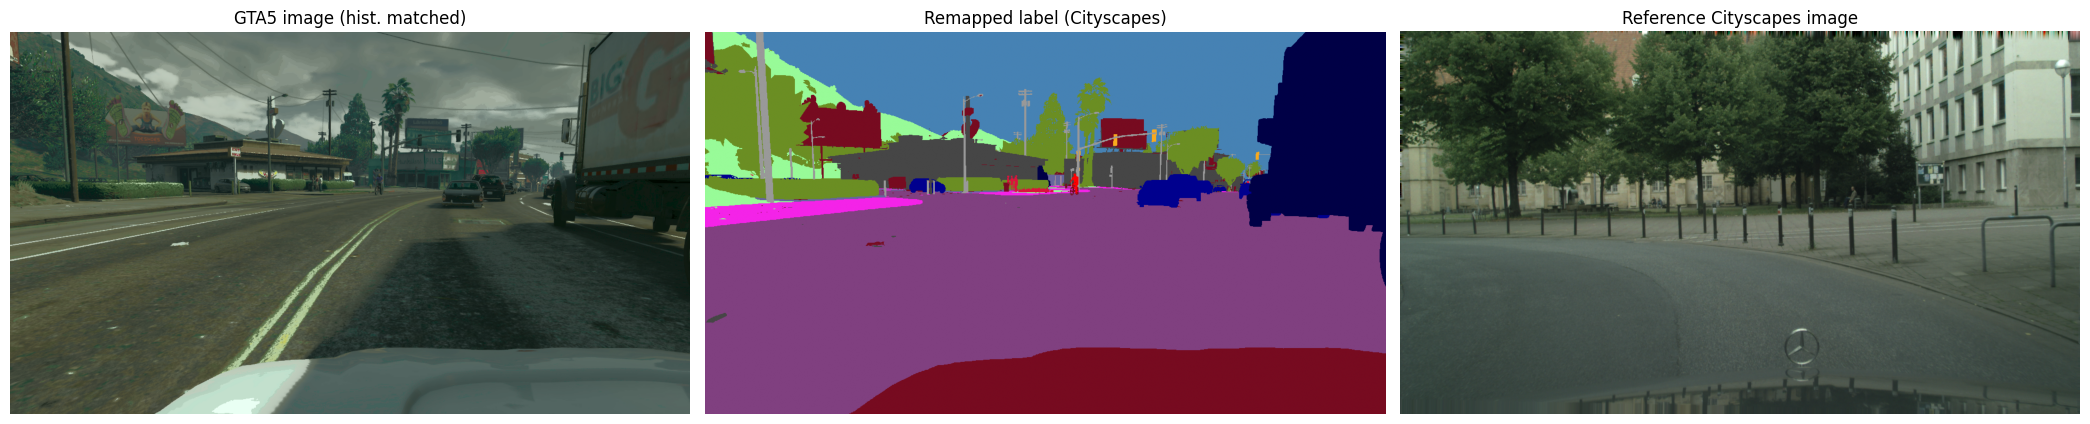

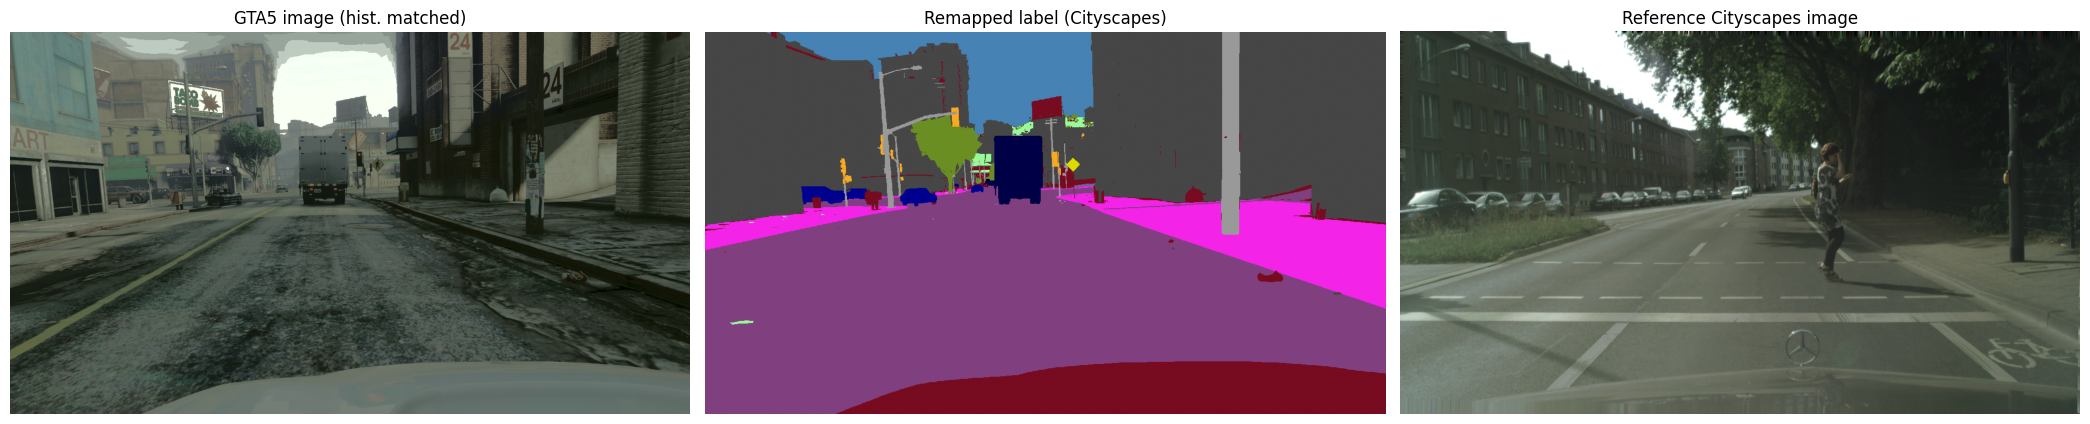

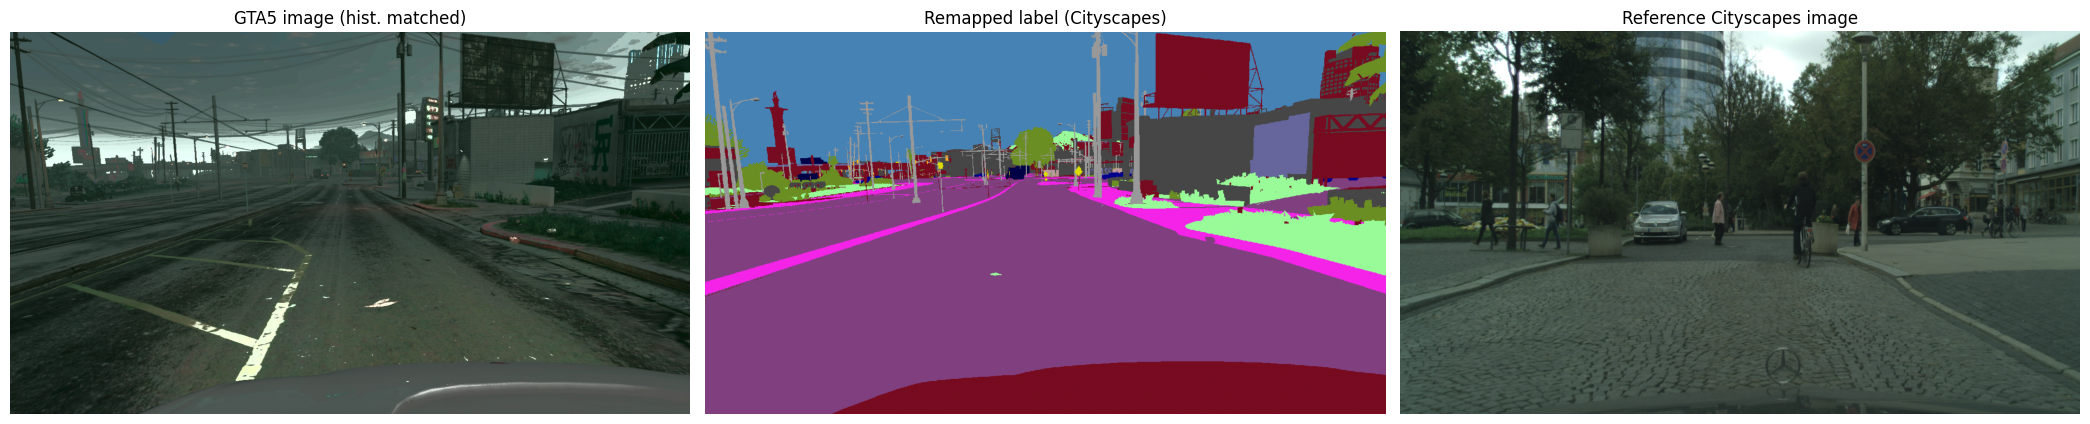

In [ ]:
import matplotlib.pyplot as plt
import torch
import random
import numpy as np
from matplotlib.colors import ListedColormap

def show_sample(dataset, idx=None):
    """
    Displays an image, its corresponding segmentation label, and the reference image from a dataset.

    Args:
        dataset: A PyTorch-style dataset object returning (image, label, ref_img) triples.
        idx (int, optional): Index of the sample to visualize. If None, a random one is selected.
    """
    if idx is None:
        idx = random.randint(0, len(dataset) - 1)

    image, label, ref_img = dataset[idx]

    if isinstance(image, torch.Tensor) and image.dim() == 3 and image.shape[0] == 3:
        image_np = image.permute(1, 2, 0).cpu().numpy()
        if image_np.max() <= 1.1:
            image_np = (image_np * 255).astype(np.uint8)
        else:
            image_np = image_np.astype(np.uint8)
    else:
        image_np = np.array(image)

    label_np = label.cpu().numpy() if isinstance(label, torch.Tensor) else np.array(label)

    if isinstance(ref_img, torch.Tensor):
        ref_np = ref_img.permute(1, 2, 0).cpu().numpy()
        if ref_np.max() <= 1.1:
            ref_np = (ref_np * 255).astype(np.uint8)
        else:
            ref_np = ref_np.astype(np.uint8)
    else:
        ref_np = np.array(ref_img)

    cityscapes_palette = [
        (128, 64,128), (244, 35,232), ( 70, 70, 70), (102,102,156),
        (190,153,153), (153,153,153), (250,170, 30), (220,220,  0),
        (107,142, 35), (152,251,152), ( 70,130,180), (220, 20, 60),
        (255,  0,  0), (  0,  0,142), (  0,  0, 70), (  0, 60,100),
        (  0, 80,100), (  0,  0,230), (119, 11, 32)
    ]
    cityscapes_palette = np.array(cityscapes_palette) / 255.0
    cmap = ListedColormap(cityscapes_palette)

    plt.figure(figsize=(21, 7))
    plt.subplot(1, 3, 1)
    plt.imshow(image_np)
    plt.title('GTA5 image (hist. matched)')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(label_np, cmap=cmap, vmin=0, vmax=18)
    plt.title('Remapped label (Cityscapes)')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(ref_np)
    plt.title('Reference Cityscapes image')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


dataset = GTA5Dataset(
    root_dir="/content/drive/MyDrive/GTA5",
    cityscapes_images_dir="/content/drive/MyDrive/Cityscapes/Cityspaces/images/train"
)

for _ in range(3):
    show_sample(dataset)


#Histogram matching

#Photometric


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from torchvision import transforms

# prepare data

batch_size = 4
data_dir_train = '/content/drive/MyDrive/GTA5'
data_dir_val = '/content/drive/MyDrive/Cityscapes/Cityspaces'

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# 5. All
transform_photometric_all = A.Compose([
    A.RandomScale(scale_limit=(0.0, 0.5), p=0.5),
    A.PadIfNeeded(min_height=720, min_width=1280,
                  border_mode=cv2.BORDER_CONSTANT,
                  value=0,
                  mask_value=255),
    A.RandomCrop(height=720, width=1280, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1, p=0.5),
    A.GaussianBlur(blur_limit=(5, 5), p=0.5),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])

image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

train_dataset_all = GTA5Dataset(
    root_dir=data_dir_train,
    cityscapes_images_dir=data_dir_val,
    image_transform=transform_photometric_all)


# Validation

val_dataset = CityscapesDataset(
    root_dir=data_dir_val, split="val",
    image_transform=image_transforms)

# Loader

train_dataloader_all = DataLoader(train_dataset_all, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


/tmp/ipython-input-8-211010427.py:18: UserWarning: Argument(s) 'value, mask_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=720, min_width=1280,


[INFO] Found 2072 Cityscapes reference images.


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


#Bisenet

In [ ]:
import torch
from torch import nn
import warnings
warnings.filterwarnings(action='ignore')

import torch
from torchvision import models
from itertools import chain


class resnet18(torch.nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features = models.resnet18(pretrained=pretrained)
        self.conv1 = self.features.conv1
        self.bn1 = self.features.bn1
        self.relu = self.features.relu
        self.maxpool1 = self.features.maxpool
        self.layer1 = self.features.layer1
        self.layer2 = self.features.layer2
        self.layer3 = self.features.layer3
        self.layer4 = self.features.layer4

    def forward(self, input):
        x = self.conv1(input)
        x = self.relu(self.bn1(x))
        x = self.maxpool1(x)
        feature1 = self.layer1(x)  # 1 / 4
        feature2 = self.layer2(feature1)  # 1 / 8
        feature3 = self.layer3(feature2)  # 1 / 16
        feature4 = self.layer4(feature3)  # 1 / 32
        # global average pooling to build tail
        tail = torch.mean(feature4, 3, keepdim=True)
        tail = torch.mean(tail, 2, keepdim=True)
        return feature3, feature4, tail


class resnet101(torch.nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features = models.resnet101(pretrained=pretrained)
        self.conv1 = self.features.conv1
        self.bn1 = self.features.bn1
        self.relu = self.features.relu
        self.maxpool1 = self.features.maxpool
        self.layer1 = self.features.layer1
        self.layer2 = self.features.layer2
        self.layer3 = self.features.layer3
        self.layer4 = self.features.layer4

    def forward(self, input):
        x = self.conv1(input)
        x = self.relu(self.bn1(x))
        x = self.maxpool1(x)
        feature1 = self.layer1(x)  # 1 / 4
        feature2 = self.layer2(feature1)  # 1 / 8
        feature3 = self.layer3(feature2)  # 1 / 16
        feature4 = self.layer4(feature3)  # 1 / 32
        # global average pooling to build tail
        tail = torch.mean(feature4, 3, keepdim=True)
        tail = torch.mean(tail, 2, keepdim=True)
        return feature3, feature4, tail


def build_contextpath(name):
    model = {
        'resnet18': resnet18(pretrained=True),
        'resnet101': resnet101(pretrained=True)
    }
    return model[name]


class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, input):
        x = self.conv1(input)
        return self.relu(self.bn(x))


class Spatial_path(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.convblock1 = ConvBlock(in_channels=3, out_channels=64)
        self.convblock2 = ConvBlock(in_channels=64, out_channels=128)
        self.convblock3 = ConvBlock(in_channels=128, out_channels=256)

    def forward(self, input):
        x = self.convblock1(input)
        x = self.convblock2(x)
        x = self.convblock3(x)
        return x


class AttentionRefinementModule(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.sigmoid = nn.Sigmoid()
        self.in_channels = in_channels
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

    def forward(self, input):
        # global average pooling
        x = self.avgpool(input)
        assert self.in_channels == x.size(1), 'in_channels and out_channels should all be {}'.format(x.size(1))
        x = self.conv(x)
        x = self.sigmoid(self.bn(x))
        # x = self.sigmoid(x)
        # channels of input and x should be same
        x = torch.mul(input, x)
        return x


class FeatureFusionModule(torch.nn.Module):
    def __init__(self, num_classes, in_channels):
        super().__init__()
        # self.in_channels = input_1.channels + input_2.channels
        # resnet101 3328 = 256(from spatial path) + 1024(from context path) + 2048(from context path)
        # resnet18  1024 = 256(from spatial path) + 256(from context path) + 512(from context path)
        self.in_channels = in_channels

        self.convblock = ConvBlock(in_channels=self.in_channels, out_channels=num_classes, stride=1)
        self.conv1 = nn.Conv2d(num_classes, num_classes, kernel_size=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(num_classes, num_classes, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

    def forward(self, input_1, input_2):
        x = torch.cat((input_1, input_2), dim=1)
        assert self.in_channels == x.size(1), 'in_channels of ConvBlock should be {}'.format(x.size(1))
        feature = self.convblock(x)
        x = self.avgpool(feature)

        x = self.relu(self.conv1(x))
        x = self.sigmoid(self.conv2(x))
        x = torch.mul(feature, x)
        x = torch.add(x, feature)
        return x


class BiSeNet(torch.nn.Module):
    def __init__(self, num_classes, context_path):
        super().__init__()
        # build spatial path
        self.saptial_path = Spatial_path()

        # build context path
        self.context_path = build_contextpath(name=context_path)

        # build attention refinement module  for resnet 101
        if context_path == 'resnet101':
            self.attention_refinement_module1 = AttentionRefinementModule(1024, 1024)
            self.attention_refinement_module2 = AttentionRefinementModule(2048, 2048)
            # supervision block
            self.supervision1 = nn.Conv2d(in_channels=1024, out_channels=num_classes, kernel_size=1)
            self.supervision2 = nn.Conv2d(in_channels=2048, out_channels=num_classes, kernel_size=1)
            # build feature fusion module
            self.feature_fusion_module = FeatureFusionModule(num_classes, 3328)

        elif context_path == 'resnet18':
            # build attention refinement module  for resnet 18
            self.attention_refinement_module1 = AttentionRefinementModule(256, 256)
            self.attention_refinement_module2 = AttentionRefinementModule(512, 512)
            # supervision block
            self.supervision1 = nn.Conv2d(in_channels=256, out_channels=num_classes, kernel_size=1)
            self.supervision2 = nn.Conv2d(in_channels=512, out_channels=num_classes, kernel_size=1)
            # build feature fusion module
            self.feature_fusion_module = FeatureFusionModule(num_classes, 1024)
        else:
            print('Error: unspport context_path network \n')

        # build final convolution
        self.conv = nn.Conv2d(in_channels=num_classes, out_channels=num_classes, kernel_size=1)

        self.init_weight()

        self.mul_lr = []
        self.mul_lr.append(self.saptial_path)
        self.mul_lr.append(self.attention_refinement_module1)
        self.mul_lr.append(self.attention_refinement_module2)
        self.mul_lr.append(self.supervision1)
        self.mul_lr.append(self.supervision2)
        self.mul_lr.append(self.feature_fusion_module)
        self.mul_lr.append(self.conv)

    def init_weight(self):
        for name, m in self.named_modules():
            if 'context_path' not in name:
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                elif isinstance(m, nn.BatchNorm2d):
                    m.eps = 1e-5
                    m.momentum = 0.1
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)

    def forward(self, input):
        # output of spatial path
        sx = self.saptial_path(input)

        # output of context path
        cx1, cx2, tail = self.context_path(input)
        cx1 = self.attention_refinement_module1(cx1)
        cx2 = self.attention_refinement_module2(cx2)
        cx2 = torch.mul(cx2, tail)
        # upsampling
        cx1 = torch.nn.functional.interpolate(cx1, size=sx.size()[-2:], mode='bilinear')
        cx2 = torch.nn.functional.interpolate(cx2, size=sx.size()[-2:], mode='bilinear')
        cx = torch.cat((cx1, cx2), dim=1)

        if self.training == True:
            cx1_sup = self.supervision1(cx1)
            cx2_sup = self.supervision2(cx2)
            cx1_sup = torch.nn.functional.interpolate(cx1_sup, size=input.size()[-2:], mode='bilinear')
            cx2_sup = torch.nn.functional.interpolate(cx2_sup, size=input.size()[-2:], mode='bilinear')

        # output of feature fusion module
        result = self.feature_fusion_module(sx, cx)

        # upsampling
        result = torch.nn.functional.interpolate(result, scale_factor=8, mode='bilinear')
        result = self.conv(result)

        if self.training == True:
            return result, cx1_sup, cx2_sup

        return result

    def optim_parameters(self, lr): # new
      return [
          {'params': self.context_path.parameters(), 'lr': lr},               # 1x
          {'params': chain(*(m.parameters() for m in self.mul_lr)), 'lr': lr * 10}  # 10x
      ]

In [ ]:
def poly_lr_scheduler(optimizer, init_lr, iter, lr_decay_iter=1,
                      max_iter=300, power=0.9):
    """Polynomial decay of learning rate
            :param init_lr is base learning rate
            :param iter is a current iteration
            :param lr_decay_iter how frequently decay occurs, default is 1
            :param max_iter is number of maximum iterations
            :param power is a polymomial power

    """

    lr = init_lr*(1 - iter/max_iter)**power
    optimizer.param_groups[0]['lr'] = lr
    optimizer.param_groups[1]['lr'] = lr * 10 # new
    return lr


def fast_hist(a, b, n):
    '''
    a and b are label and prediction respectively
    n is the number of classes
    '''
    k = (a >= 0) & (a < n)
    return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)


def per_class_iou(hist):
    epsilon = 1e-5
    return (np.diag(hist)) / (hist.sum(1) + hist.sum(0) - np.diag(hist) + epsilon)

In [ ]:
CITYSCAPES_CLASSES = [
    'Road', 'Sidewalk', 'Building', 'Wall', 'Fence', 'Pole', 'Traffic light',
    'Traffic sign', 'Vegetation', 'Terrain', 'Sky', 'Person', 'Rider', 'Car',
    'Truck', 'Bus', 'Train', 'Motorcycle', 'Bicycle'
]

**Trainig**

#All

In [ ]:
from tqdm import tqdm

learning_rate = 1e-2
epochs = 50

model = BiSeNet(num_classes=19, context_path='resnet18')
optimizer = optim.SGD(model.optim_parameters(learning_rate), momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(ignore_index=255)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BiSeNet(
  (saptial_path): Spatial_path(
    (convblock1): ConvBlock(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (convblock2): ConvBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (convblock3): ConvBlock(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
  )
  (context_path): resnet18(
    (features): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

Epoch 1/50, Loss: 0.8404


Per-class IoU
Road            : 0.6388
Sidewalk        : 0.3810
Building        : 0.6706
Wall            : 0.0559
Fence           : 0.0000
Pole            : 0.1133
Traffic light   : 0.0000
Traffic sign    : 0.0000
Vegetation      : 0.7693
Terrain         : 0.2446
Sky             : 0.7474
Person          : 0.0000
Rider           : 0.0000
Car             : 0.4050
Truck           : 0.0358
Bus             : 0.0000
Train           : 0.0033
Motorcycle      : 0.0000
Bicycle         : 0.0000
Mean IoU: 0.2139
Best model saved at epoch 1 with mIoU=0.2139


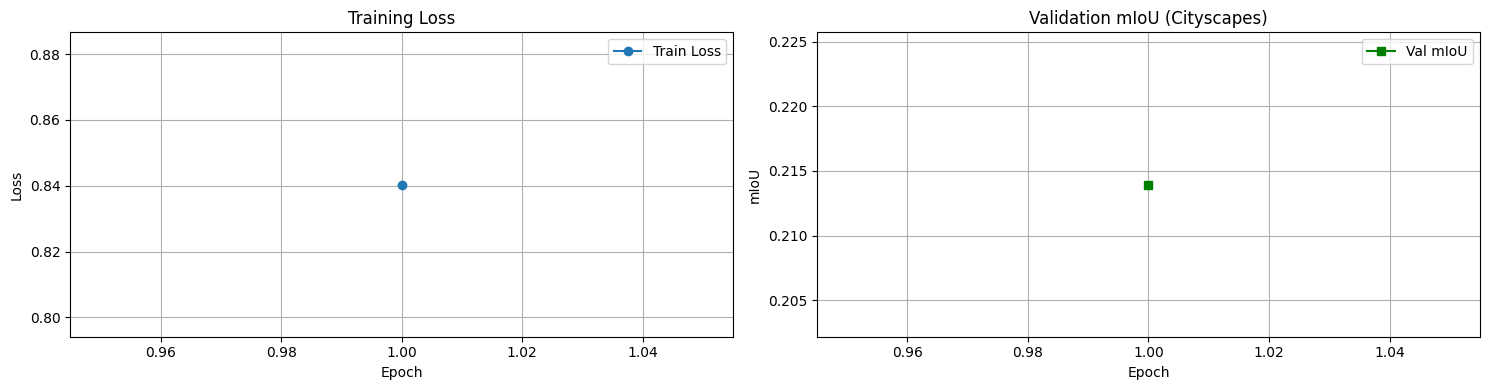

Epoch 2/50, Loss: 0.6809


Per-class IoU
Road            : 0.7696
Sidewalk        : 0.3516
Building        : 0.7033
Wall            : 0.1743
Fence           : 0.1101
Pole            : 0.1296
Traffic light   : 0.0000
Traffic sign    : 0.0000
Vegetation      : 0.7827
Terrain         : 0.2753
Sky             : 0.7739
Person          : 0.0402
Rider           : 0.0000
Car             : 0.4844
Truck           : 0.2096
Bus             : 0.0041
Train           : 0.1856
Motorcycle      : 0.0000
Bicycle         : 0.0000
Mean IoU: 0.2629
Best model saved at epoch 2 with mIoU=0.2629


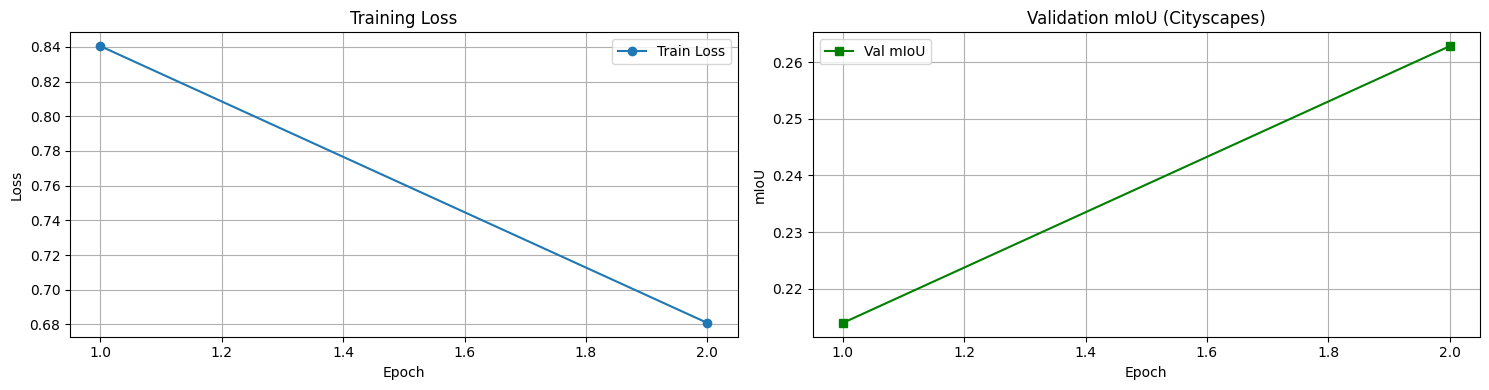

Epoch 3/50, Loss: 0.6040


Per-class IoU
Road            : 0.6607
Sidewalk        : 0.2822
Building        : 0.6518
Wall            : 0.1123
Fence           : 0.1384
Pole            : 0.1064
Traffic light   : 0.0388
Traffic sign    : 0.0000
Vegetation      : 0.7703
Terrain         : 0.2475
Sky             : 0.7933
Person          : 0.3009
Rider           : 0.0000
Car             : 0.4735
Truck           : 0.1704
Bus             : 0.0009
Train           : 0.0423
Motorcycle      : 0.0000
Bicycle         : 0.0000
Mean IoU: 0.2521


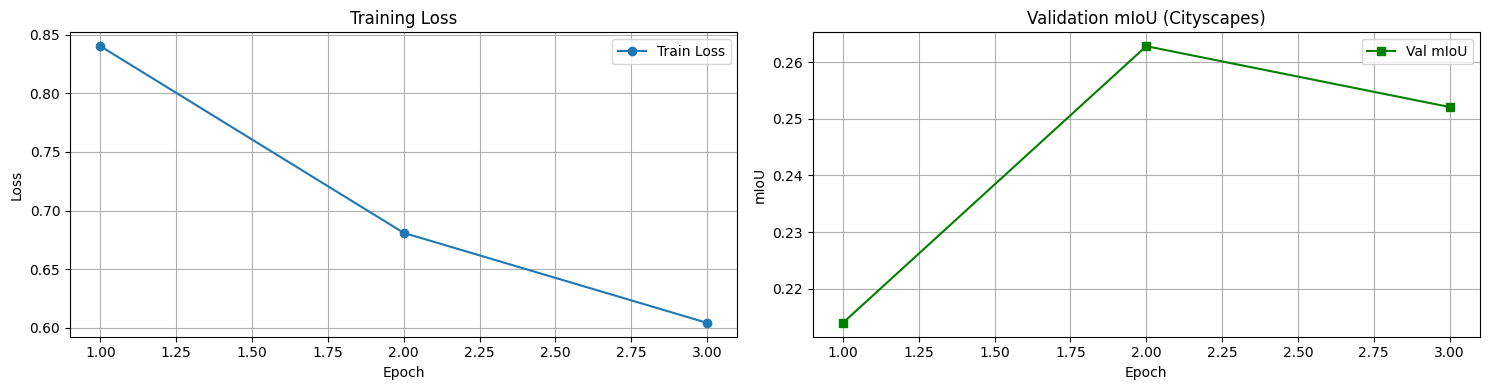

Epoch 4/50, Loss: 0.5538


Per-class IoU
Road            : 0.7254
Sidewalk        : 0.2422
Building        : 0.6857
Wall            : 0.2033
Fence           : 0.1295
Pole            : 0.1459
Traffic light   : 0.1305
Traffic sign    : 0.1064
Vegetation      : 0.7733
Terrain         : 0.2862
Sky             : 0.7377
Person          : 0.3096
Rider           : 0.0065
Car             : 0.5261
Truck           : 0.1541
Bus             : 0.0188
Train           : 0.0023
Motorcycle      : 0.0436
Bicycle         : 0.0000
Mean IoU: 0.2751
Best model saved at epoch 4 with mIoU=0.2751


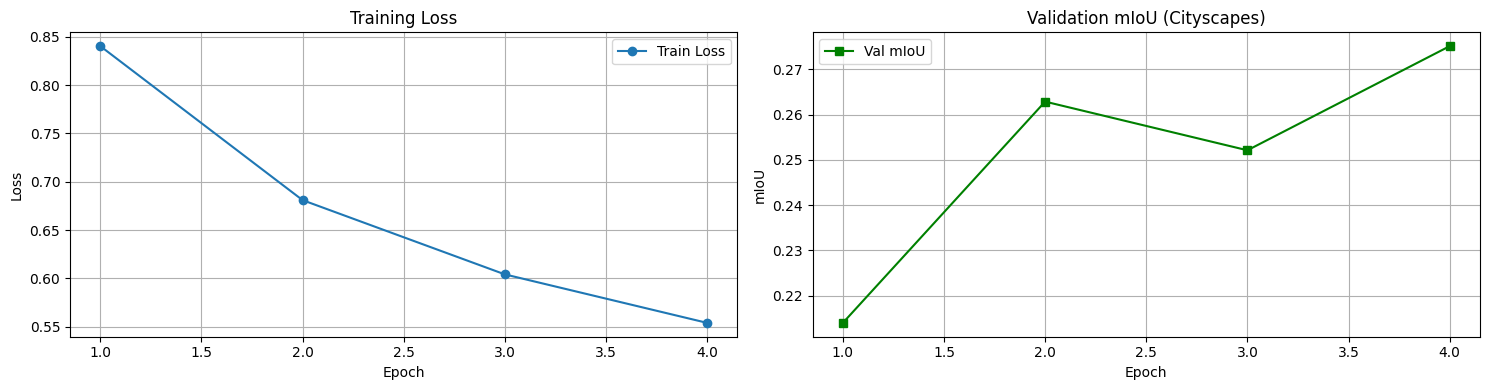

Epoch 5/50, Loss: 0.5298


Per-class IoU
Road            : 0.7239
Sidewalk        : 0.2189
Building        : 0.7069
Wall            : 0.1384
Fence           : 0.1126
Pole            : 0.1200
Traffic light   : 0.0828
Traffic sign    : 0.0587
Vegetation      : 0.7887
Terrain         : 0.2281
Sky             : 0.8323
Person          : 0.3604
Rider           : 0.0072
Car             : 0.4646
Truck           : 0.1143
Bus             : 0.1589
Train           : 0.0000
Motorcycle      : 0.0244
Bicycle         : 0.0000
Mean IoU: 0.2706
Checkpoint saved at /content/drive/MyDrive/Bisenet_Histogram_Matching_OnTheFly/checkpoint_all.pth


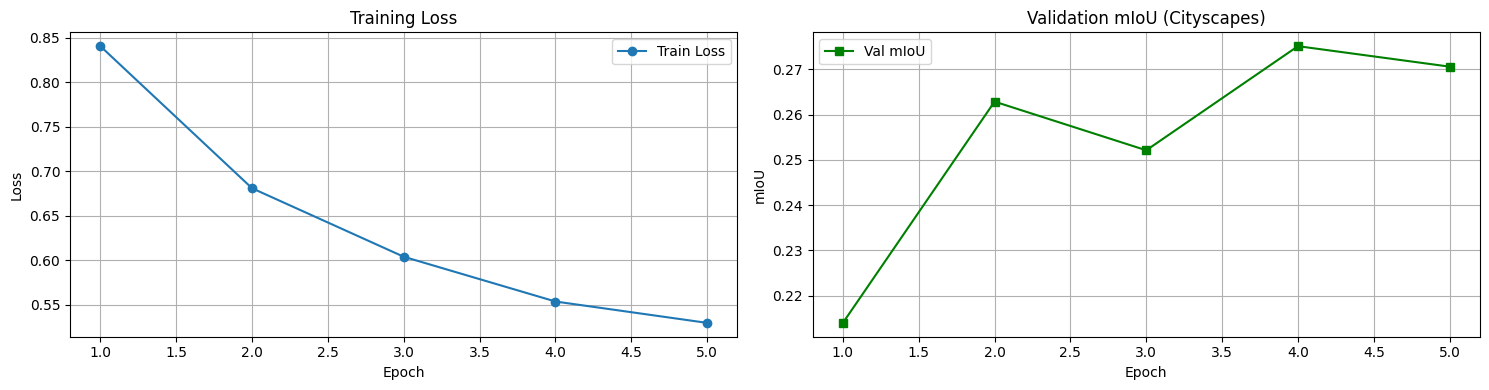

Epoch 6/50, Loss: 0.5008


Per-class IoU
Road            : 0.7312
Sidewalk        : 0.3136
Building        : 0.7512
Wall            : 0.1458
Fence           : 0.1311
Pole            : 0.1509
Traffic light   : 0.1199
Traffic sign    : 0.0934
Vegetation      : 0.7846
Terrain         : 0.2801
Sky             : 0.7544
Person          : 0.1906
Rider           : 0.0614
Car             : 0.4057
Truck           : 0.1906
Bus             : 0.0016
Train           : 0.0000
Motorcycle      : 0.0359
Bicycle         : 0.0000
Mean IoU: 0.2706


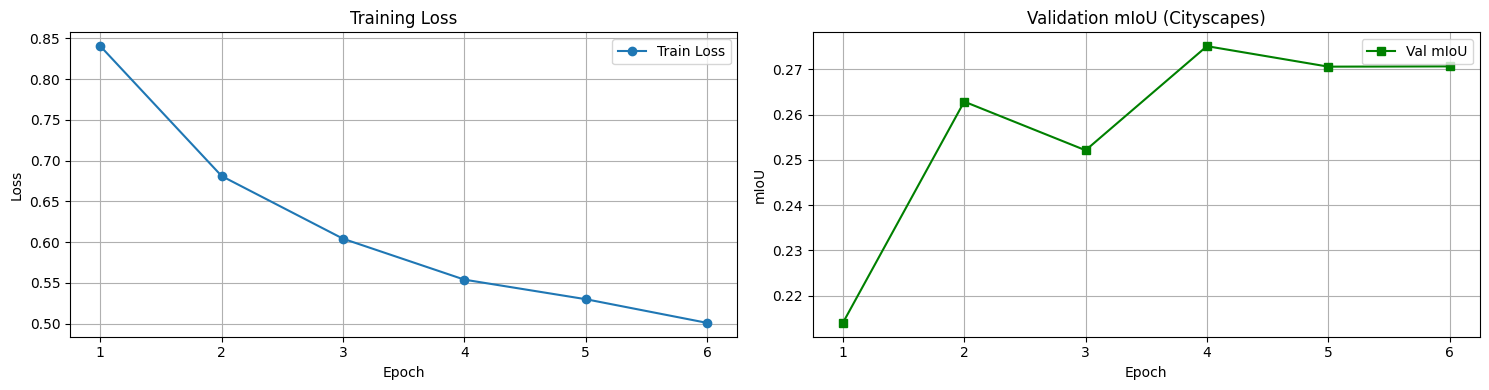

Epoch 7/50, Loss: 0.4977


Per-class IoU
Road            : 0.6941
Sidewalk        : 0.2692
Building        : 0.6829
Wall            : 0.2064
Fence           : 0.1650
Pole            : 0.1766
Traffic light   : 0.1679
Traffic sign    : 0.1507
Vegetation      : 0.8128
Terrain         : 0.3189
Sky             : 0.7233
Person          : 0.3623
Rider           : 0.0960
Car             : 0.4514
Truck           : 0.2459
Bus             : 0.2223
Train           : 0.0128
Motorcycle      : 0.0313
Bicycle         : 0.0000
Mean IoU: 0.3047
Best model saved at epoch 7 with mIoU=0.3047


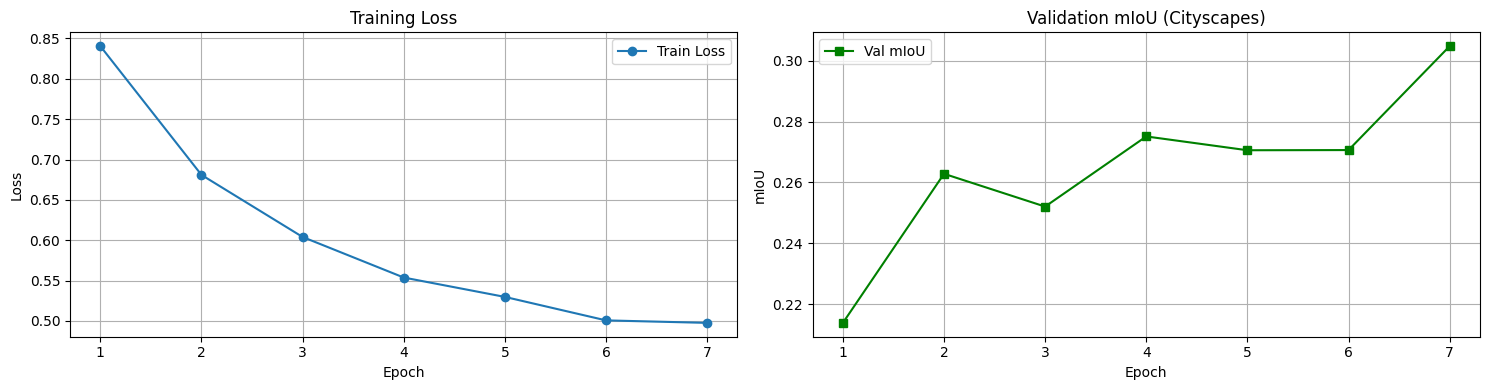

Epoch 8/50, Loss: 0.4815


Per-class IoU
Road            : 0.2809
Sidewalk        : 0.2687
Building        : 0.5965
Wall            : 0.1500
Fence           : 0.1413
Pole            : 0.1632
Traffic light   : 0.1765
Traffic sign    : 0.1259
Vegetation      : 0.8000
Terrain         : 0.2892
Sky             : 0.7902
Person          : 0.3578
Rider           : 0.0024
Car             : 0.2881
Truck           : 0.2015
Bus             : 0.0001
Train           : 0.0000
Motorcycle      : 0.0257
Bicycle         : 0.0000
Mean IoU: 0.2452


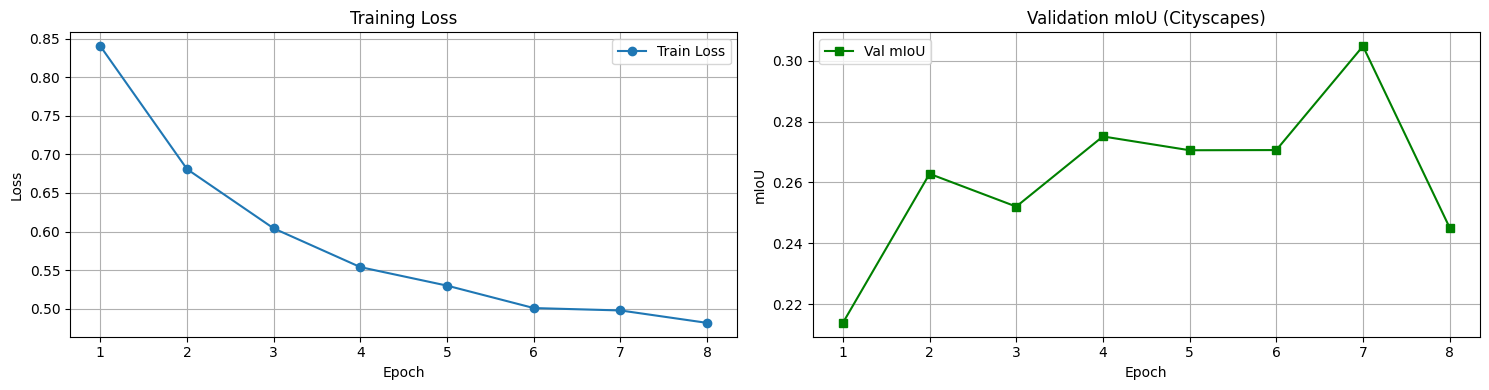

Epoch 9/50, Loss: 0.4685


Per-class IoU
Road            : 0.7428
Sidewalk        : 0.3180
Building        : 0.6388
Wall            : 0.1861
Fence           : 0.1744
Pole            : 0.1511
Traffic light   : 0.1485
Traffic sign    : 0.0897
Vegetation      : 0.7889
Terrain         : 0.3418
Sky             : 0.7773
Person          : 0.3397
Rider           : 0.0267
Car             : 0.7173
Truck           : 0.1231
Bus             : 0.1511
Train           : 0.0004
Motorcycle      : 0.0367
Bicycle         : 0.0000
Mean IoU: 0.3027


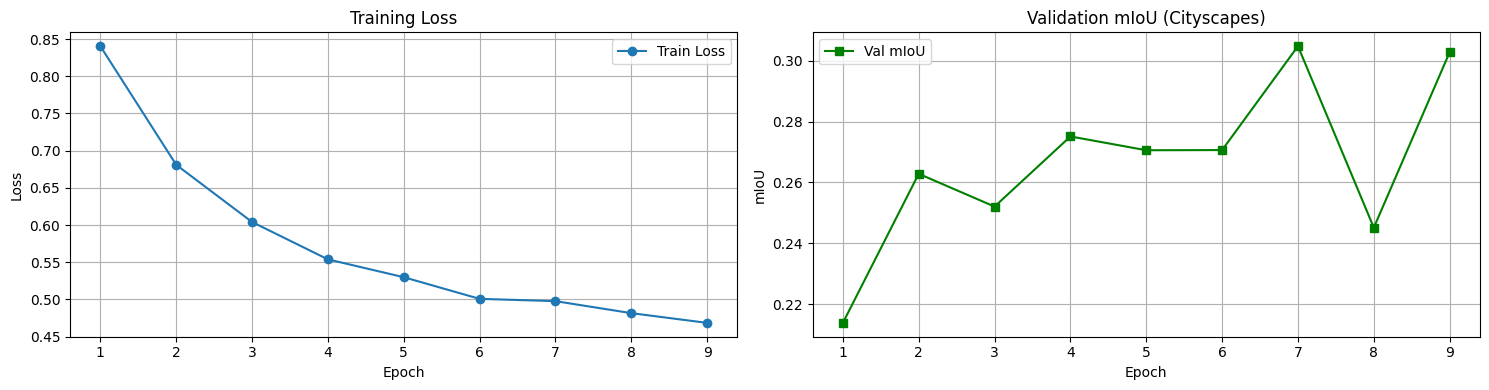

Epoch 10/50, Loss: 0.4532


Per-class IoU
Road            : 0.8252
Sidewalk        : 0.2902
Building        : 0.7477
Wall            : 0.1820
Fence           : 0.1410
Pole            : 0.1845
Traffic light   : 0.1564
Traffic sign    : 0.1443
Vegetation      : 0.8162
Terrain         : 0.2517
Sky             : 0.8052
Person          : 0.3723
Rider           : 0.0348
Car             : 0.7068
Truck           : 0.0990
Bus             : 0.1323
Train           : 0.0255
Motorcycle      : 0.0655
Bicycle         : 0.0000
Mean IoU: 0.3148
Checkpoint saved at /content/drive/MyDrive/Bisenet_Histogram_Matching_OnTheFly/checkpoint_all.pth
Best model saved at epoch 10 with mIoU=0.3148


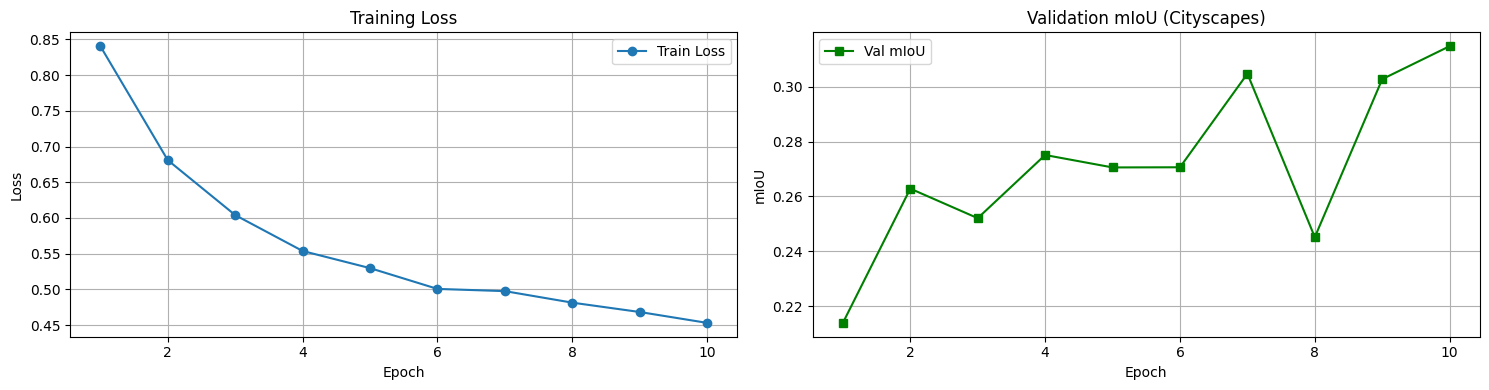

Epoch 11/50, Loss: 0.4397


Per-class IoU
Road            : 0.4949
Sidewalk        : 0.3116
Building        : 0.7511
Wall            : 0.1797
Fence           : 0.0736
Pole            : 0.2208
Traffic light   : 0.2003
Traffic sign    : 0.1300
Vegetation      : 0.8163
Terrain         : 0.2868
Sky             : 0.8219
Person          : 0.3269
Rider           : 0.0343
Car             : 0.3122
Truck           : 0.0815
Bus             : 0.2547
Train           : 0.0037
Motorcycle      : 0.0502
Bicycle         : 0.0000
Mean IoU: 0.2816


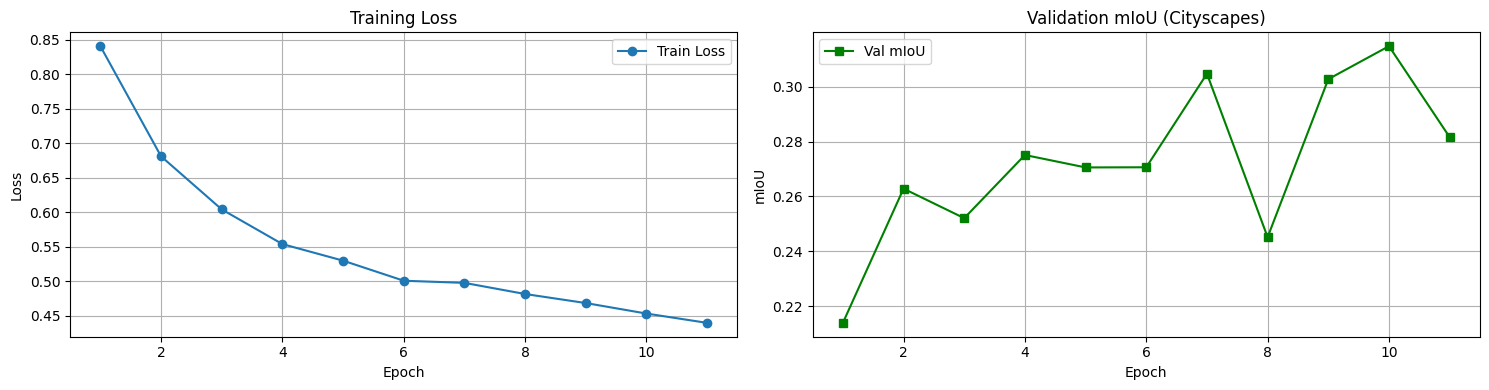

Epoch 12/50, Loss: 0.4343


Per-class IoU
Road            : 0.5960
Sidewalk        : 0.2270
Building        : 0.6264
Wall            : 0.0989
Fence           : 0.1115
Pole            : 0.1435
Traffic light   : 0.2027
Traffic sign    : 0.1319
Vegetation      : 0.7885
Terrain         : 0.2784
Sky             : 0.7841
Person          : 0.3834
Rider           : 0.0947
Car             : 0.6065
Truck           : 0.0263
Bus             : 0.0474
Train           : 0.0756
Motorcycle      : 0.0508
Bicycle         : 0.0000
Mean IoU: 0.2776


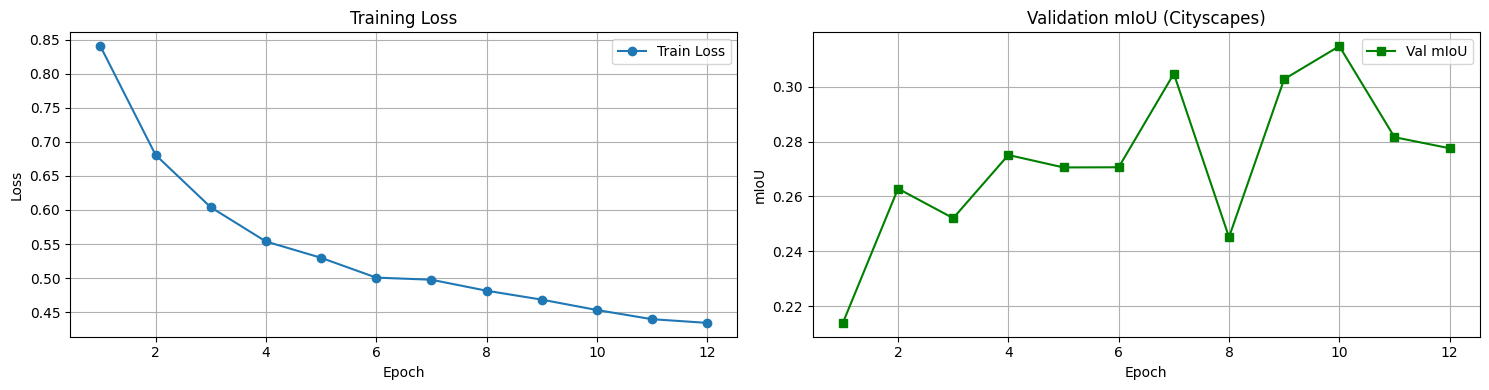

Epoch 13/50, Loss: 0.4285


Per-class IoU
Road            : 0.7495
Sidewalk        : 0.3153
Building        : 0.6597
Wall            : 0.2040
Fence           : 0.1705
Pole            : 0.1757
Traffic light   : 0.1851
Traffic sign    : 0.1426
Vegetation      : 0.8002
Terrain         : 0.3245
Sky             : 0.7146
Person          : 0.3708
Rider           : 0.0072
Car             : 0.6473
Truck           : 0.1970
Bus             : 0.1437
Train           : 0.0233
Motorcycle      : 0.0493
Bicycle         : 0.0000
Mean IoU: 0.3095


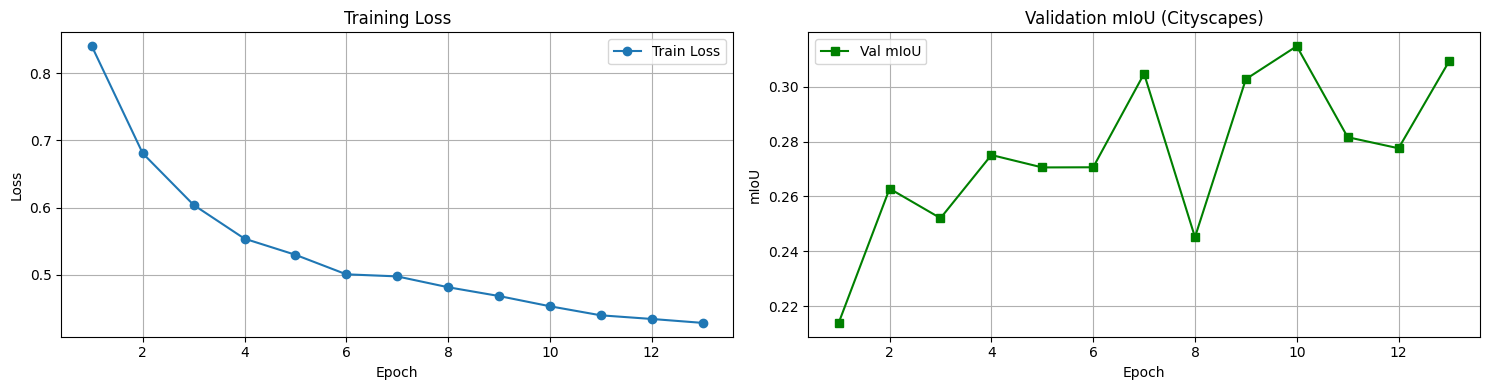

Epoch 14/50, Loss: 0.4253


Per-class IoU
Road            : 0.8090
Sidewalk        : 0.3619
Building        : 0.7639
Wall            : 0.2423
Fence           : 0.1527
Pole            : 0.1141
Traffic light   : 0.1771
Traffic sign    : 0.1789
Vegetation      : 0.8095
Terrain         : 0.2948
Sky             : 0.7850
Person          : 0.3993
Rider           : 0.0350
Car             : 0.6406
Truck           : 0.0831
Bus             : 0.0969
Train           : 0.0000
Motorcycle      : 0.0436
Bicycle         : 0.0000
Mean IoU: 0.3151
Best model saved at epoch 14 with mIoU=0.3151


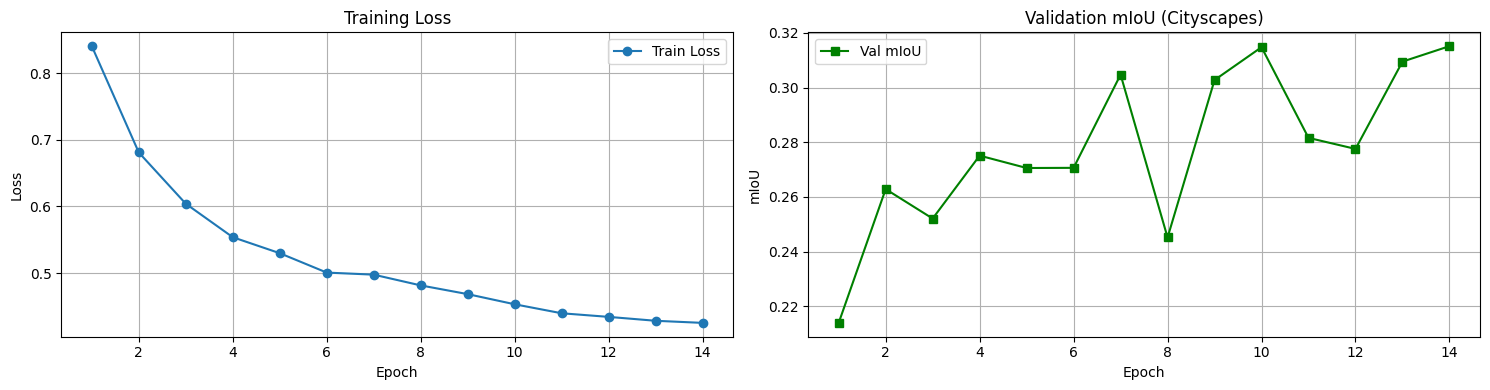

Epoch 15/50, Loss: 0.4131


Per-class IoU
Road            : 0.6362
Sidewalk        : 0.3433
Building        : 0.7546
Wall            : 0.1324
Fence           : 0.1341
Pole            : 0.2007
Traffic light   : 0.2080
Traffic sign    : 0.1466
Vegetation      : 0.8191
Terrain         : 0.3034
Sky             : 0.7777
Person          : 0.4054
Rider           : 0.0490
Car             : 0.3705
Truck           : 0.0583
Bus             : 0.0859
Train           : 0.0605
Motorcycle      : 0.0748
Bicycle         : 0.0000
Mean IoU: 0.2927
Checkpoint saved at /content/drive/MyDrive/Bisenet_Histogram_Matching_OnTheFly/checkpoint_all.pth


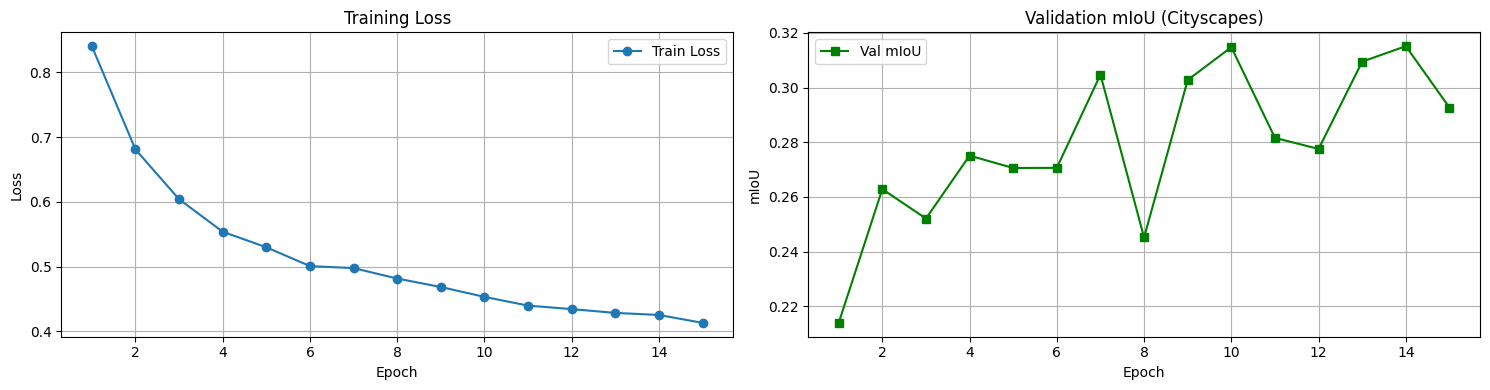

KeyboardInterrupt: 

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import torchvision.transforms.functional as TF
import pandas as pd
import torch.nn.functional as F

train_dataloader = train_dataloader_all

log_path = '/content/drive/MyDrive/Bisenet_Histogram_Matching_OnTheFly/bisenet_train_log_all.csv'
chkpt = "/content/drive/MyDrive/Bisenet_Histogram_Matching_OnTheFly/checkpoint_all.pth"
lossmiou = '/content/drive/MyDrive/Bisenet_Histogram_Matching_OnTheFly/bisenet_loss_miou_plot_all.png'

checkpoint_dir = os.path.dirname(chkpt)
os.makedirs(checkpoint_dir, exist_ok=True)
scaler = GradScaler()
charbonnier_eps = 1e-6
charbonnier_alpha = 0.5
lambda_ent = 0.001

# Load checkpoint if available
if os.path.exists(chkpt):
    print(f"Restoring checkpoint from {chkpt}")
    checkpoint = torch.load(chkpt, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scaler.load_state_dict(checkpoint['scaler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    iteration = checkpoint['iteration']
else:
    start_epoch = 0
    iteration = 0

best_miou = 0
max_iter = len(train_dataloader) * epochs

# Load log dataframe from CSV if it exists
if os.path.exists(log_path):
    log_df = pd.read_csv(log_path)
    train_losses = log_df["train_loss"].tolist()
    val_mious = log_df["val_miou"].tolist()
else:
    log_df = pd.DataFrame(columns=['epoch', 'train_loss', 'val_miou'])
    train_losses = []
    val_mious = []

for epoch in range(start_epoch, epochs):
    model.train()
    running_loss = 0.0
    train_loader_tqdm = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
    for batch_idx, (images, masks, target_images) in enumerate(train_loader_tqdm):

      images = images.to(device)
      masks = masks.to(device, dtype=torch.long)
      target_images = target_images.to(device)

      optimizer.zero_grad()
      with autocast():
          outputs, aux1, aux2 = model(images)

          loss_main = criterion(outputs, masks)
          loss_aux1 = criterion(aux1, masks)
          loss_aux2 = criterion(aux2, masks)
          loss_ce = loss_main + 0.4 * loss_aux1 + 0.4 * loss_aux2

          logits_t = model(target_images)[0]
          probs_t = F.softmax(logits_t, dim=1)
          safe_probs = probs_t.clamp(min=1e-8)
          H = -torch.sum(safe_probs * torch.log(safe_probs), dim=1)
          loss_ent = torch.mean((H**2 + charbonnier_eps**2)**charbonnier_alpha)

          loss = loss_ce + lambda_ent * loss_ent

          scaler.scale(loss).backward()
          poly_lr_scheduler(optimizer, learning_rate, iteration, max_iter=max_iter)
          iteration += 1
          scaler.step(optimizer)
          scaler.update()
          running_loss += loss.item()
          train_loader_tqdm.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_dataloader)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

    # Validation
    model.eval()
    hist = np.zeros((19, 19))
    val_loader_tqdm = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False)
    with torch.no_grad():
        for images, masks in val_loader_tqdm:
            images = images.to(device)
            masks = masks.to(device, dtype=torch.long)
            with autocast():
                outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            targets = masks.cpu().numpy()
            targets[targets == 255] = -1
            for lt, lp in zip(targets, preds):
                valid = lt >= 0
                hist += fast_hist(lt[valid].flatten(), lp[valid].flatten(), 19)
    # metrics
    ious = per_class_iou(hist)
    epoch_miou = np.nanmean(ious)
    val_mious.append(epoch_miou)
    print("Per-class IoU")
    for idx, (cls_name, iou) in enumerate(zip(CITYSCAPES_CLASSES, ious)):
        print(f"{cls_name:16s}: {iou:.4f}")
    print(f"Mean IoU: {epoch_miou:.4f}")

    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'iteration': iteration,
            'scaler_state_dict': scaler.state_dict()
        }, chkpt)
        print(f"Checkpoint saved at {chkpt}")

    # Save best model
    if epoch_miou > best_miou:
        best_miou = epoch_miou
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'iteration': iteration,
            'scaler_state_dict': scaler.state_dict()
        }, chkpt.replace(".pth", "_best.pth"))
        print(f"Best model saved at epoch {epoch+1} with mIoU={best_miou:.4f}")

    # Plot loss and mIoU
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(val_mious) + 1), val_mious, marker='s', color='green', label='Val mIoU')
    plt.xlabel('Epoch')
    plt.ylabel('mIoU')
    plt.title('Validation mIoU (Cityscapes)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    if (epoch + 1) == epochs:
        plt.savefig(lossmiou)
    plt.show()
    plt.close()

    log_df.loc[len(log_df)] = {
        'epoch': epoch + 1,
        'train_loss': epoch_loss,
        'val_miou': epoch_miou
    }
    log_df.to_csv(log_path, index=False)